In [2]:
#Packages
using DifferentialEquations
using PyPlot


In [3]:
####### MODEL A #######

# This script is for model a, the compartmental model model comprised of 
# 17 ODEs describing the concentration of NP in each of five organ
# compartments: lung heart kindey liver spleen. All parameter values 
# correspond to values representative of a murine model.


# Define the intial concentration that enters in the vein

###################################   Physiological Parameter Values from literature   ###########################################

A_i     = [.0019956689,.0009621096822,.0033612343,.0045212562,.0004750356]*1000 # dm^2, crossectional area of cell free layer above EC

l_NC_b  = (10^(-6)) #dm, length of the nanocarrier bond
                  
Q_i     = [1100.83758415,138.673326,763.9168803,284.6716878,224.48828292]/(60*10^6) #L/sec, blood flow rate in each organ
      
V_i_BL  = [43.65525742,20.04395171,1018.55584,127.7673516,2.226207538]/10^6 #L, volume of blood in each organ
          
V_i_T   = [33.26114851,16.03516137,56.02057122,75.3542703,7.91726]/10^6 #L, tissue volume of each organ compartment
          
V_vein  = 466.9/10^6 # L, volume of blood in the veins (and also the arteries
          
Q = Q_i[1]+Q_i[2]+Q_i[3]+Q_i[4]+Q_i[5] #L/sec total flow rate

4.1876462686166666e-5

In [4]:
############################################   Rate Parameters  #####################################################
slope1 = (22-4)/(500-50)
slope2 = 3.9
slope = slope1*slope2
a = [4, 15, 50, 79, 100]
r = a/2
K_EC0=[1.23e42, 10.6565662, 41793.3924, 2.28e12, 7.74e21, 3.33e15, 3.33e15] #162
K_EC0 = log.(K_EC0)
K_EC = zeros(5, 7)
for i =1:7
    K_EC[1:4,i] = slope*r[1:4] .- slope*r[end] .+ K_EC0[i]
    K_EC[end, i] = K_EC0[i]
end
K_EC[:, 2] .= K_EC0[2]

Kb = 1.36e-23	
T = 310	
mu = 0.0037	
l = 1e-7
r = r*1e-9
D=Kb*T./(6*pi*mu*r)	
k_i_on = D./l^2	
K_i_on = zeros(5, 7)
K_i_off = zeros(5, 7)
for i = 1:5
  K_i_on[i, :] .= k_i_on[i]
  K_i_off[i, :] = K_i_on[i]./K_EC[i, :]  
end

K_i_on = K_i_on[5, :]
K_i_off = K_i_off[5, :]
p = [2.0e-4 1 1.0; 2.0e-6 0.1 0.02; 0.0005 3.35e-3 0.002; 5.0e-6 0.005 0.02; 5.0e-5 0.1 1.43e-2; 3.355e-5 0.01 0.02; 3.35e-5 0.01 0.02]
K_i_deg = p[1:5, 1]
K_i_up = p[1:5, 2]
K_NS= p[1:5, 3]

5-element Vector{Float64}:
 1.0
 0.02
 0.002
 0.02
 0.0143

In [5]:
######################################   Experimental Validation data from Dong 2019   ###########################################
#defining the discrete time points 
time_dong = [0, 5, 30, 60, 120]*60
kidney_dong_100 = [0, 1.326803, .75, .5, .25]
liver_dong_100 = [0, 64.3331574 ,80.1237696, 83.0615579 ,84.1632286]
spleen_dong_100 = [0 ,3.4820602 ,3.21158546 ,3.15035765 ,3.04021763]
heart_dong = 3.3389
lung_dong = 0.40230

0.4023

In [6]:
################### Define the system of 17 linear ODEs #################   
function odefun(dydt, y, p, t)     
    #vein
    dydt[1] = (Q_i[1]*y[3]/V_i_BL[1]+Q_i[2]*y[4]/V_i_BL[2]+Q_i[3]*y[5]/V_i_BL[3]+Q_i[4]*y[6]/V_i_BL[4]+Q_i[5]*y[7]/V_i_BL[5])-Q*y[1]/V_vein

    #artery
    dydt[2] = ((Q*y[1]-(Q_i[1]*y[2]+Q_i[2]*y[2]+Q_i[3]*y[2]+Q_i[4]*y[2]+Q_i[5]*y[2]))/(V_vein))

    ##################### Vascular compartment #########################

    #lung 
    dydt[3] = (Q_i[1]*y[2]/V_vein-Q_i[1]*y[3]/V_i_BL[1]-K_i_on[1]*y[3]+K_i_off[1]*y[8]-K_NS[1]*y[3]-y[3]*K_i_deg[1])

    #heart 
    dydt[4] = (Q_i[2]*y[2]/V_vein-Q_i[2]*y[4]/V_i_BL[2]-K_i_on[2]*y[4]+K_i_off[2]*y[9]-K_NS[2]*y[4]-y[4]*K_i_deg[2])

    #kidney
    dydt[5] = (Q_i[3]*y[2]/V_vein-Q_i[3]*y[5]/V_i_BL[3]-K_i_on[3]*y[5]+K_i_off[3]*y[10]-K_NS[3]*y[5]-y[5]*K_i_deg[3])

    #liver
    dydt[6] = (Q_i[4]*y[2]/V_vein-Q_i[4]*y[6]/V_i_BL[4]-K_i_on[4]*y[6]+K_i_off[4]*y[11]-K_NS[4]*y[6]-y[6]*K_i_deg[4])

    #spleen
    dydt[7] = (Q_i[5]*y[2]/V_vein-Q_i[5]*y[7]/V_i_BL[5]-K_i_on[5]*y[7]+K_i_off[5]*y[12]-K_NS[5]*y[7]-y[7]*K_i_deg[5])

    ##################### Endothelial Cell compartment #########################

    #lung
    dydt[8] = (-K_i_up[1]*y[8]+K_i_on[1]*y[3]-K_i_off[1]*y[8]-y[8]*K_i_deg[1])

    #heart
    dydt[9] = (-K_i_up[2]*y[9]+K_i_on[2]*y[4]-K_i_off[2]*y[9]-y[9]*K_i_deg[2])

    #kidney
    dydt[10] = (-K_i_up[3]*y[10]+K_i_on[3]*y[5]-K_i_off[3]*y[10]-y[10]*K_i_deg[3])

    #liver
    dydt[11] = (-K_i_up[4]*y[11]+K_i_on[4]*y[6]-K_i_off[4]*y[11]-y[11]*K_i_deg[4])

    #spleen
    dydt[12] = (-K_i_up[5]*y[12]+K_i_on[5]*y[7]-K_i_off[5]*y[12]-y[12]*K_i_deg[5])

    #################### Tissue Compartment ###########################

    #Lung
    dydt[13] = (K_i_up[1]*y[8]+K_NS[1]*y[3]-K_i_deg[1]*y[13])

    #heart
    dydt[14] = (K_i_up[2]*y[9]+K_NS[2]*y[4]-K_i_deg[2]*y[14])

    #kidney
    dydt[15] = (K_i_up[3]*y[10]+K_NS[3]*y[5]-K_i_deg[3]*y[15])

    #liver
    dydt[16] = (K_i_up[4]*y[11]+K_NS[4]*y[6]-K_i_deg[4]*y[16])

    #spleen
    dydt[17] = (K_i_up[5]*y[12]+K_NS[5]*y[7]-K_i_deg[5]*y[17])

    #Degredation Terms
    dydt[18] = sum((y[3:7]+y[8:12]+y[13:17]).*K_i_deg)
end

odefun (generic function with 1 method)

In [7]:
#Solving Model A
y0=[1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
tspan = (0.0, 1e4)
prob = ODEProblem(odefun, y0, tspan)
sol_ub = solve(prob, AutoTsit5(Rosenbrock23()))

retcode: Success
Interpolation: automatic order switching interpolation
t: 100-element Vector{Float64}:
     0.0
     0.011138317416594318
     0.025760622608524422
     0.04673438926348519
     0.07588497740115169
     0.11320829460234531
     0.14430471464268319
     0.1639834155626291
     0.18226134966292934
     0.20087931015228888
     0.22034226359571535
     0.2406278526246332
     0.2614036772721213
     ⋮
  2649.3176570693377
  3070.303551276804
  3619.0390772417436
  4195.2294041813675
  4851.38636260316
  5529.711847978981
  6261.2344917044975
  7011.405949196834
  7798.211540924558
  8603.879212735616
  9441.037590352977
 10000.0
u: 100-element Vector{Vector{Float64}}:
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.9990014988064493, 0.0009980029969624553, 1.4621245334765037e-7, 1.955619916443056e-8, 1.030969489357788e-7, 3.809337639226792e-8, 2.983454310242624e-8, 7.121111827537513e-8, 7.953125923098184e-9, 4.850946891598158

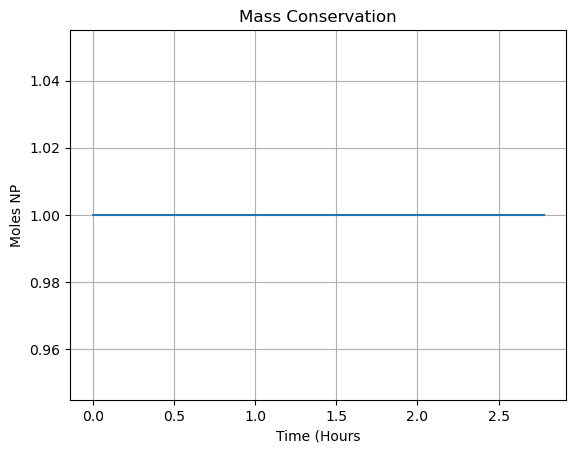

In [40]:
#Plot for mass consevation
mass = sum(sol_ub, dims=1)
mass = vec(mass)
mass = round.(mass)
plot(sol_ub.t/3600, mass)
PyPlot.title("Mass Conservation")
xlabel("Time (Hours")
ylabel("Moles NP")
rc("xtick", labelsize=10)
rc("ytick", labelsize=10)
grid()
# plot(sol_ub.t/3600, mass, ylim=(0.5, 1.5),, ylabel=,,
#              legend = false,size=(500,200),xtickfontsize=8,yguidefontsize=10,xguidefontsize=9, ytickfontsize=8)

In [8]:
#Plot for concentration profile
plot_array = Any[]
push!(plot_array, plot(0.0001.+sol_ub.t./3600, sol_ub[1:2, :]', xaxis=:log,title="Vein/Artery",legend = :right, size=(650,750), label=["Vein" "Artery"]))
names_new = ["Lungs", "Heart", "Kidney", "Liver", "Spleen"]
for i = 13:17
  if i==13
    p1 = plot(0.0001.+sol_ub.t./3600, sol_ub[i, :]*V_vein/V_i_T[i-12], xaxis=:log)
    p2 = scatter!([float(time_dong[end])]/3600, [lung_dong], title=names_new[i-12],legend = false, size=(650,750))
    push!(plot_array, p2)
  elseif i==14
    p1 = plot(0.0001.+sol_ub.t./3600, sol_ub[i, :]*V_vein/V_i_T[i-12], xaxis=:log)
    p2 = scatter!([float(time_dong[end])]/3600, [heart_dong], title=names_new[i-12],legend = false, size=(650,750))
    push!(plot_array, p2)    
  elseif i==15
    p1 = plot(0.0001.+sol_ub.t./3600, sol_ub[i, :]*V_vein/V_i_T[i-12], xaxis=:log)
    p2 = scatter!(0.0001.+float(time_dong)/3600, kidney_dong_100, title=names_new[i-12],legend = false, size=(650,750))
    push!(plot_array, p2)        
  elseif i==16
    push!(plot_array, plot(0.0001.+sol_ub.t./3600, (sol_ub[i, :])*V_vein/V_i_T[i-12], xaxis=:log, title=names_new[i-12],legend = false, size=(650,750)))
  elseif i==17
    p1 = plot(0.0001.+sol_ub.t./3600, sol_ub[i, :]*V_vein/V_i_T[i-12], xaxis=:log)
    p2 = scatter!(0.0001.+float(time_dong)/3600, spleen_dong_100, title=names_new[i-12],legend = false, size=(650,750))
    push!(plot_array, p2)       
  end
end
plot(plot_array..., layout=(3, 2), xlabel="Time (Hours)",xtickfontsize=10, ytickfontsize=10)